<a href="https://colab.research.google.com/github/kunal-git-002/Detectron-2/blob/master/pt6_draw_the_lines_for_multiple_person.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pt 6 : draw the lines for multiple person

> 








# preavious data 


In [168]:
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd

In [169]:

# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [170]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [171]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

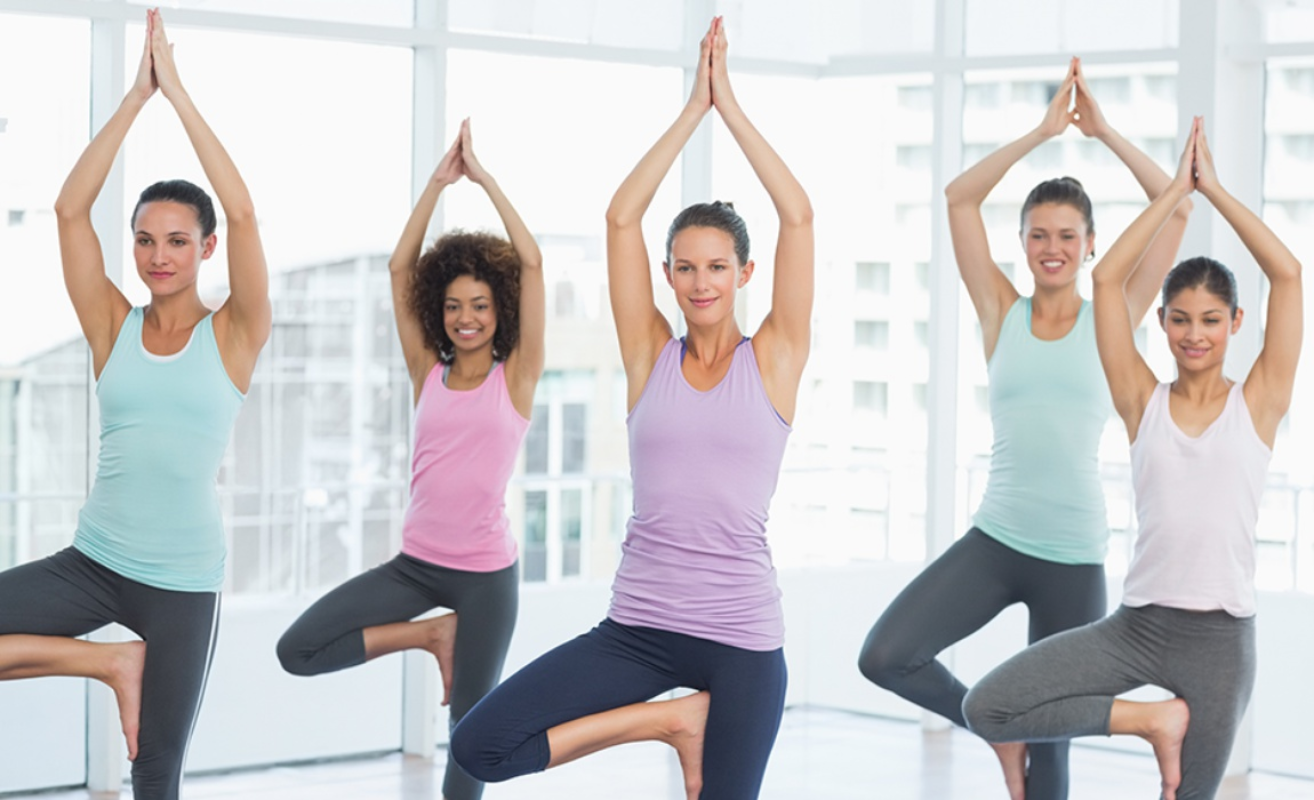

In [172]:
def read_img(path):
  img=cv2.imread(path)
  h,w,ch=img.shape

  new_h=800
  ratio=h/new_h

  new_w=int(w/ratio)

  return cv2.resize(img,(new_w,new_h))

img = read_img("/content/drive/My Drive/imgs/more8.jpg")

cv2_imshow(img)

In [173]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = predictor(img)#return a dictionaries

v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

#cv2_imshow(out.get_image()[:, :, ::-1])

***step 1 : getting all the information***

In [174]:

ins=outputs["instances"]#create output instance

op_data=ins.get_fields()#this return a all the imp data like, bboxes,confidence score,keypoints locations & classes

keypoints_data=op_data["pred_keypoints"]

#conversion of data into numpy array

#data is first moved to cpu and then converted to numpy array
keypoints_data = keypoints_data.cpu().data.numpy()

#now numpy array
keypoints_data=keypoints_data=np.array(keypoints_data)

In [175]:
keypoints_data.shape

(6, 17, 3)

In [176]:
n,k,_=keypoints_data.shape
#n=num of instanves
#k=num of keypoints per instances
#_=3 ,becz we have three values (x,y,visbility)

#indexes of human keypoints according Detectron 2 keypoints model
human_keypoints={0: 'nose',
 1: 'left_eye',
 2: 'right_eye',
 3: 'left_ear',
 4: 'right_ear',
 5: 'left_shoulder',
 6: 'right_shoulder',
 7: 'left_elbow',
 8: 'right_elbow',
 9: 'left_wrist',
 10: 'right_wrist',
 11: 'left_hip',
 12: 'right_hip',
 13: 'left_knee',
 14: 'right_knee',
 15: 'left_ankle',
 16: 'right_ankle'}

all_kps={}

for i in range(n):
  kps=keypoints_data[i]

  temp_dic={}
  for j in range(len(kps)):

    x,y,vis=kps[j]
    #x,y,vis=int(x),int(y),int(vis)
    temp_dic[j]=(human_keypoints[j],
                 (x,y))
  
  all_kps[i]=temp_dic


convert into pandas dataframe

In [177]:

kps=[i for i in human_keypoints.values()]
keypoints_locs_df=pd.DataFrame(data=kps)
keypoints_locs_df.rename(columns={0:"human part"},inplace=True)

for ins in range(n):
  kps=all_kps[ins]
  temp_li=[]
  for ind,val in kps.items():
    part,locs=val
    temp_li.append(locs)
  keypoints_locs_df["person_"+str(ins)+" (x,y)"]=temp_li

keypoints_locs_df.set_index("human part",drop=True)

,"person_0 (x,y)","person_1 (x,y)","person_2 (x,y)","person_3 (x,y)","person_4 (x,y)","person_5 (x,y)"
human part,,,,,,
nose,"(160.0217, 257.01288)","(699.13745, 279.92844)","(466.30875, 319.71802)","(1051.8109, 247.71523)","(1193.9277, 334.5935)","(701.9293, 281.08685)"
left_eye,"(176.01553, 241.03291)","(718.1063, 261.94382)","(480.29797, 305.72278)","(1068.7806, 234.72934)","(1210.9272, 320.6107)","(715.9253, 265.10638)"
right_eye,"(145.02747, 241.03291)","(685.1604, 262.94296)","(452.31952, 306.7224)","(1037.8358, 234.72934)","(1179.9282, 320.6107)","(683.9345, 266.10516)"
left_ear,"(208.00322, 245.02791)","(745.06213, 272.93442)","(503.28027, 309.72144)","(1088.745, 244.71848)","(1236.9265, 322.60822)","(743.91724, 274.0954)"
right_ear,"(131.03285, 246.02666)","(670.185, 276.931)","(437.33105, 310.72107)","(1022.86255, 245.71739)","(1160.9287, 321.60944)","(666.93945, 269.1015)"
left_shoulder,"(230.99437, 338.91022)","(772.0179, 365.85495)","(517.26953, 378.69806)","(1106.7129, 320.636)","(1259.9259, 408.50256)","(772.90894, 356.99402)"
right_shoulder,"(121.036705, 327.924)","(652.2145, 358.86093)","(429.3372, 373.69977)","(1007.8893, 319.6371)","(1143.9292, 402.50995)","(654.9429, 356.99402)"
left_elbow,"(239.9909, 214.06671)","(796.9769, 216.98227)","(531.2588, 264.73663)","(1106.7129, 274.6859)","(1288.925, 274.66718)","(797.90173, 214.16869)"
right_elbow,"(71.05595, 213.06796)","(623.26196, 216.98227)","(401.3587, 266.73596)","(958.97656, 196.77058)","(1115.93, 284.6549)","(624.95154, 214.16869)"


# draw the lines

> we dont consider left eye, right eye ,left ear & right ear point




***step 1 :find all points for draw lines***

In [178]:
line_points_main={}

for col in keypoints_locs_df.columns[1:]: 
  temp_li=[]

  for i in range(k):
    x,y=keypoints_locs_df[col][i]
    locs=(int(x),int(y))

    #cv2.circle(img,locs,2,(0,255,0),-1)

    if 0<i<5:#skiping the 1,2,3,4 point
      pass

    else:

      temp_li.append(locs)

  col=col.split(" ")[0]
  line_points_main[col]=temp_li
      

  


#for connecting 0 point & center of (7,8) point
#first we find center of (7,8)
#x_,y_=(np.array(line_points[7])+np.array(line_points[8]))/2
#x_,y_=int(x_),int(y_)
line_points_main


{'person_0': [(160, 257),
  (230, 338),
  (121, 327),
  (239, 214),
  (71, 213),
  (176, 92),
  (136, 103),
  (180, 586),
  (93, 559),
  (160, 778),
  (4, 630),
  (117, 657),
  (116, 656)],
 'person_1': [(699, 279),
  (772, 365),
  (652, 358),
  (796, 216),
  (623, 216),
  (725, 99),
  (691, 113),
  (743, 650),
  (639, 633),
  (471, 749),
  (471, 748),
  (684, 719),
  (678, 716)],
 'person_2': [(466, 319),
  (517, 378),
  (429, 373),
  (531, 264),
  (401, 266),
  (484, 177),
  (434, 186),
  (484, 583),
  (418, 565),
  (470, 736),
  (296, 650),
  (437, 632),
  (433, 630)],
 'person_3': [(1051, 247),
  (1106, 320),
  (1007, 319),
  (1106, 274),
  (958, 196),
  (1105, 137),
  (1040, 131),
  (1073, 556),
  (998, 538),
  (1078, 690),
  (887, 658),
  (1119, 722),
  (999, 721)],
 'person_4': [(1193, 334),
  (1259, 408),
  (1143, 402),
  (1288, 274),
  (1115, 284),
  (1219, 198),
  (1035, 120),
  (1220, 642),
  (1139, 626),
  (982, 709),
  (997, 707),
  (1158, 713),
  (1151, 712)],
 'person_5'

***step 2 : visulize the data on white frame***

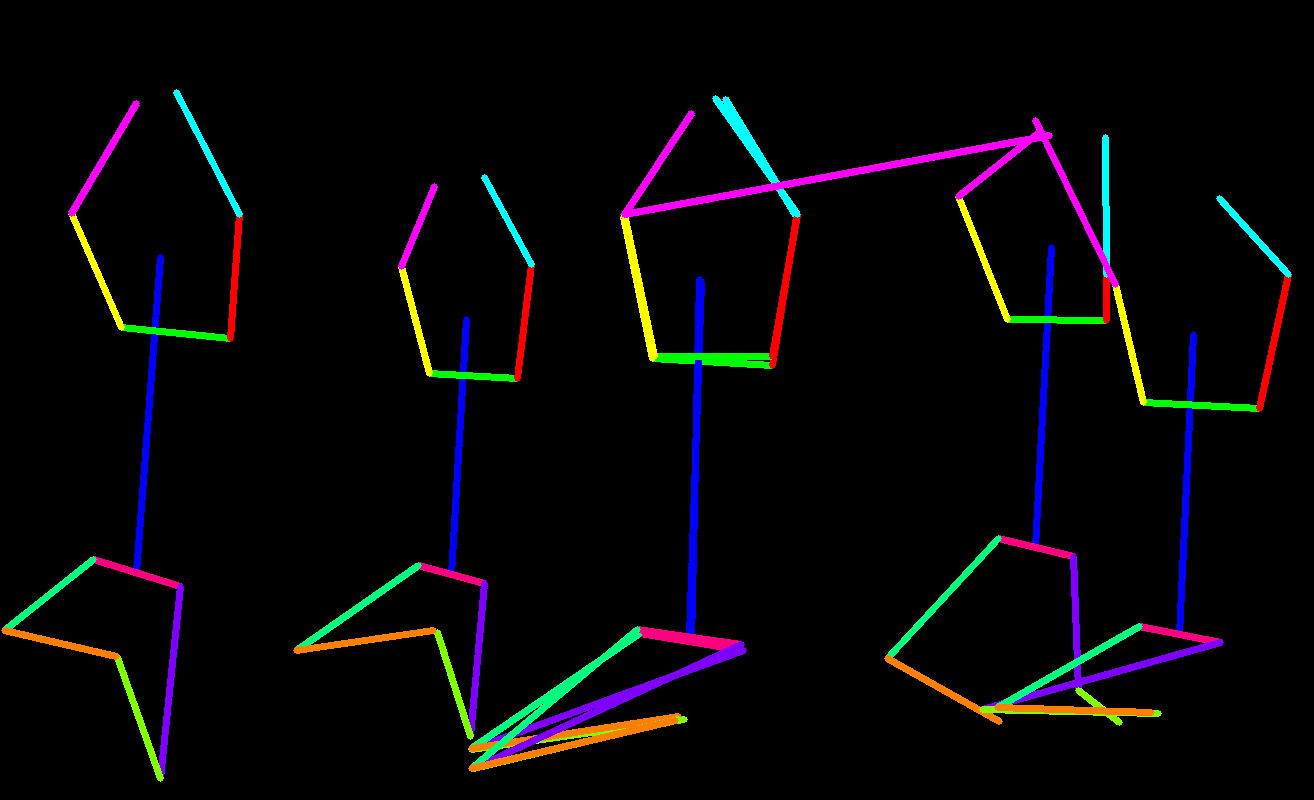

In [179]:
#we make new white frame for see only lines
white_frame=np.zeros(shape=img.shape,dtype=np.uint8)
fm=white_frame

j=0
for i in line_points_main.keys():
  line_points=line_points_main[i]
  
  x_,y_=(np.array(line_points[7])+np.array(line_points[8]))/2
  x_,y_=int(x_),int(y_)  
  #colors for lines
  colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(255,127,0),
          (255,0,127),(0,255,127),(127,255,0),(0,127,255),(127,0,255),(0,0,0)]

  #thickness
  thi=5

  for i in [0,1,2,7,8]:

    if i==0:

      cv2.line(fm,line_points[i],(x_,y_),colors[0],thi)#nose to center of right & left hip

    elif i==1:

      cv2.line(fm,line_points[i],line_points[i+1],colors[1],thi)#left shoulder to right shoulder 
      cv2.line(fm,line_points[i],line_points[i+2],colors[2],thi)#left shoulder to left elbow
      cv2.line(fm, line_points[i+2],line_points[i+4],colors[3],thi)#left elbow to left wrist

    elif i==2:

      cv2.line(fm,line_points[i],line_points[i+2],colors[4],thi)#right shoulder to right right elbow
      cv2.line(fm,line_points[i+2],line_points[i+4],colors[5],thi)#right elbow to right wrist

    elif i==7:

      cv2.line(fm,line_points[i],line_points[i+1],colors[11],thi)#left hip tp right hip
      cv2.line(fm,line_points[i],line_points[i+2],colors[7],thi)#left hip to left knee
      cv2.line(fm, line_points[i+2],line_points[i+4],colors[8],thi)#left knee to left ankle

    elif i==8:

      cv2.line(fm,line_points[i],line_points[i+2],colors[9],thi)#right hip to right knee
      cv2.line(fm,line_points[i+2],line_points[i+4],colors[10],thi)#right knee to right ankle
    
  j+=1
  
  if j==len(line_points_main.keys()):
    cv2_imshow(fm)
  



  